In [1]:
from pandas_datareader import data as pdr
# pip install pandas-datareader
import quandl
# pip install quandl
from googlefinance import getQuotes
# pip install googlefinance
import json

In [22]:
# import
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib  # save model

In [142]:
# Data
stockName = 'TOP'
startDate = '2003-1-1'
endDate = '2021-1-1'

In [143]:
def QueryStockIndex(name, startDate, endDate):
    data = pdr.get_data_yahoo(name, start=startDate, end=endDate)
    return data

In [144]:
stock = QueryStockIndex(stockName + '.BK', startDate, endDate)
print(stock)

             High    Low   Open  Close       Volume  Adj Close
Date                                                          
2004-10-26  44.50  40.25  42.00  44.00    3083006.0  20.860548
2004-10-27  43.25  41.50  42.75  41.75  136964100.0  19.793812
2004-10-28  42.50  39.50  42.25  40.00  126021400.0  18.964142
2004-10-29  41.00  39.00  39.50  40.50   41203700.0  19.201185
2004-11-01  41.25  40.25  40.75  40.75   19119800.0  19.319710
...           ...    ...    ...    ...          ...        ...
2020-12-24  53.00  51.50  52.25  52.25    8876600.0  51.627445
2020-12-25  54.00  52.50  52.75  54.00    8690000.0  53.356594
2020-12-28  54.75  51.25  54.25  51.25   11987600.0  50.639362
2020-12-29  53.25  51.25  51.50  53.25    9664700.0  52.615532
2020-12-30  53.75  51.75  53.25  52.00    7177500.0  51.380424

[3976 rows x 6 columns]


In [145]:
def QueryOilPrice(startDate, endDate):
    quandl.ApiConfig.api_key = "RgFSGT7KyM8eqQzDgers"
    OilPrice = quandl.get("OPEC/ORB", start_date=startDate, end_date=endDate)
    return OilPrice

In [146]:
OPEC = QueryOilPrice(startDate, endDate)
print(OPEC)

            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
...           ...
2020-12-24  50.31
2020-12-28  50.10
2020-12-29  50.16
2020-12-30  50.22
2020-12-31  50.24

[4643 rows x 1 columns]


In [147]:
# write stock data to list
indexStock = []
dataStock = []
closeStock = []
for index, row in stock.iterrows():
    
    date = str(index)[:10]
    indexStock.append(date)
    
    temp = []
    temp.append(row.High)
    temp.append(row.Low)
    temp.append(row.Open)
    temp.append(row.Close)
    temp.append(row.Volume)
    dataStock.append(temp)

    closeStock.append(row.Close)

In [148]:
# write OPEC to list
indexOil = []
dataOil = []
for index, row in OPEC.iterrows():
    date = str(index)[:10]
    indexOil.append(date)

    dataOil.append(row.Value)

In [161]:
# Split date
dateTest = '2020-06' # 2020-06 or 2020-01

In [162]:
# cleaning data
TrainStock = []
TrainOil = []
TestStock = []
TestOil = []
testflag = False
for i in indexStock:
    for j in indexOil:
        if(i[:7] == dateTest):
            testflag = True
        
        if (i == j) and not(testflag):
            TrainStock.append(dataStock[indexStock.index(i)])
            TrainOil.append(dataOil[indexOil.index(j)])
        elif (i==j) and testflag:
            TestStock.append(dataStock[indexStock.index(i)])
            TestOil.append(dataOil[indexStock.index(i)])

In [163]:
print('Train = ' + str(len(TrainStock)) + ' (' + str(len(TrainStock)/(len(TrainStock)+len(TestStock))) + ')')
print('Test = ' + str(len(TestStock)) + ' (' + str(len(TestStock)/(len(TrainStock)+len(TestStock))) + ')')

Train = 3806 (0.9645210339584389)
Test = 140 (0.035478966041561075)


In [170]:
# Data split
n = 7
n_stock, n_oil = n, n

rangeDate = n_stock
if n_oil > n_stock:
    rangeDate = n_oil

# Train
X_train = []
y_train = []
for i in range(len(TrainStock)-rangeDate):
    temp = []
    for s in range(n_stock):
        for j in range(5):
            temp.append(TrainStock[i+s][j])
    for o in range(n_oil):
        temp.append(TrainOil[i+o])
    X_train.append(temp)
    y_train.append(TrainStock[i+rangeDate][3])

# Test
X_test = []
y_test = []
for i in range(len(TestStock)-rangeDate):
    temp = []
    for s in range(n_stock):
        for j in range(5):
            temp.append(TestStock[i+s][j])
    for o in range(n_oil):
        temp.append(TestOil[i+o])
    X_test.append(temp)
    y_test.append(TestStock[i+rangeDate][3])

In [171]:
# load the model from disk
# loadName = './model/best/' + stockName + '.joblib'
loaded_model = joblib.load('./model/TOP/TOP0.9354324656204187_Date2020-06_nstock7_noil7_C19_eps0.3.joblib')

print('Load model success!!!')

Load model success!!!


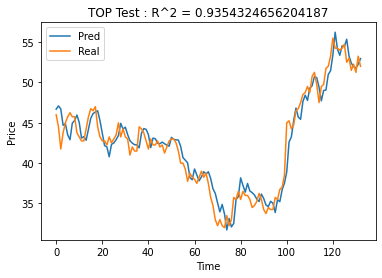

In [172]:
import matplotlib.pyplot as plt

a = []

for i in range(len(X_test)):
    test = loaded_model.predict([X_test[i]])
    a.append(test[0])
plt.plot(a, label='Pred')
plt.plot(y_test, label='Real')

R2 = loaded_model.score(X_test, y_test)
rmse = RMSE(y_test, a)
plt.title(stockName + ' Test : R^2 = ' + str(R2))
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
saveGraph = './plot/TOP/' + stockName + 'Date' + str(dateTest) + 'N' + str(n_stock) + '.png'
plt.savefig(saveGraph, dpi=200)
plt.show()
plt.close() 

In [27]:
import math
def RMSE(y_actual, y_predicted):
    rmse = 0
    temp = 0
    temp2 = 0
    for i in range(len(y_actual)):
        # temp += math.pow((y_actual[i] - y_predicted[i]),2)
        temp += (y_actual[i] - y_predicted[i])*(y_actual[i] - y_predicted[i])

        # print('Real : ' + str(y_actual[i]) + '\t Pred : ' + str(y_predicted[i]))

    temp2 = temp/len(y_actual)
    # print(temp2)
    rmse = math.sqrt(temp2)

    return rmse

print('Define RMSE')

Define RMSE
